In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import copy
from matplotlib import pyplot as plt
import random

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_clients = 5
num_rounds = 10
batch_size = 64
lr = 0.01
GLOBAL_MODEL_PATH = "global_model.pth"

client_epochs = [1, 2, 3, 4, 5]
participation_rate = 0.5
assert len(client_epochs) == num_clients

In [3]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [4]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 15.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 476kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.43MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.33MB/s]


In [5]:
def partition_dataset(dataset, num_clients):
    size_per_client = len(dataset) // num_clients
    indices = torch.randperm(len(dataset))
    return [indices[i*size_per_client:(i+1)*size_per_client].tolist() for i in range(num_clients)]

In [16]:
client_indices = partition_dataset(train_dataset, num_clients)
client_data_sizes = [len(indices) for indices in client_indices]

In [7]:
def evaluate_model(model):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)
    return 100.0 * correct / total

In [8]:
def server_init_model():
    model = CNN().to(device)
    torch.save(model.state_dict(), GLOBAL_MODEL_PATH)

In [9]:
def local_train(client_id, epochs, lr=0.01, batch_size=64):
    model = CNN().to(device)
    model.load_state_dict(torch.load(GLOBAL_MODEL_PATH))
    model.train()

    client_subset = Subset(train_dataset, client_indices[client_id])
    client_loader = DataLoader(client_subset, batch_size=batch_size, shuffle=True)

    optimizer = optim.SGD(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for _ in range(epochs):
        for data, target in client_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

    torch.save(model.state_dict(), f"client_{client_id}_model.pth")
    return len(client_subset), epochs

In [10]:
def server_aggregate_fedavg(selected_clients):
    client_dicts = [torch.load(f"client_{cid}_model.pth") for cid in selected_clients]
    avg_dict = copy.deepcopy(client_dicts[0])

    for k in avg_dict.keys():
        for i in range(1, len(client_dicts)):
            avg_dict[k] += client_dicts[i][k]
        avg_dict[k] = avg_dict[k] / len(client_dicts)

    global_model = CNN().to(device)
    global_model.load_state_dict(avg_dict)
    torch.save(global_model.state_dict(), GLOBAL_MODEL_PATH)

In [11]:
def server_aggregate_fednova(selected_clients, client_data_sizes, client_epochs):
    client_dicts = [torch.load(f"client_{cid}_model.pth") for cid in selected_clients]
    global_model = CNN().to(device)
    global_model.load_state_dict(torch.load(GLOBAL_MODEL_PATH))
    global_dict = global_model.state_dict()

    tau_eff = sum([client_data_sizes[i] * client_epochs[i] for i in selected_clients])

    new_dict = {}
    for k in global_dict.keys():
        new_dict[k] = torch.zeros_like(global_dict[k])
        for idx, cid in enumerate(selected_clients):
            new_dict[k] += client_dicts[idx][k] * client_data_sizes[cid] * client_epochs[cid]
        new_dict[k] /= tau_eff

    global_model.load_state_dict(new_dict)
    torch.save(global_model.state_dict(), GLOBAL_MODEL_PATH)


In [12]:
def run_fedavg():
    server_init_model()
    acc_list = []
    for rnd in range(num_rounds):
        num_selected = max(1, int(num_clients * participation_rate))
        selected_clients = random.sample(range(num_clients), num_selected)
        for cid in selected_clients:
            local_train(cid, epochs=client_epochs[cid], lr=lr, batch_size=batch_size)
        server_aggregate_fedavg(selected_clients)
        model = CNN().to(device)
        model.load_state_dict(torch.load(GLOBAL_MODEL_PATH))
        acc = evaluate_model(model)
        acc_list.append(acc)
        print(f"FedAvg Round {rnd+1}: {acc:.2f}%")
    return acc_list

In [13]:
def run_fednova():
    server_init_model()
    acc_list = []
    for rnd in range(num_rounds):
        num_selected = max(1, int(num_clients * participation_rate))
        selected_clients = random.sample(range(num_clients), num_selected)

        for cid in selected_clients:
            local_train(cid, epochs=client_epochs[cid], lr=lr, batch_size=batch_size)

        server_aggregate_fednova(selected_clients, client_data_sizes, client_epochs)

        model = CNN().to(device)
        model.load_state_dict(torch.load(GLOBAL_MODEL_PATH))
        acc = evaluate_model(model)
        acc_list.append(acc)
        print(f"FedNova Round {rnd+1}: {acc:.2f}%")
    return acc_list


In [14]:
print("Running FedAvg with heterogeneous local epochs...")
acc_fedavg = run_fedavg()

Running FedAvg with heterogeneous local epochs...
FedAvg Round 1: 89.21%
FedAvg Round 2: 90.34%
FedAvg Round 3: 94.04%
FedAvg Round 4: 95.10%
FedAvg Round 5: 96.13%
FedAvg Round 6: 95.99%
FedAvg Round 7: 96.71%
FedAvg Round 8: 96.70%
FedAvg Round 9: 97.17%
FedAvg Round 10: 97.23%


In [17]:
print("\nRunning FedNova with heterogeneous local epochs...")
acc_fednova = run_fednova()


Running FedNova with heterogeneous local epochs...
FedNova Round 1: 89.55%
FedNova Round 2: 92.38%
FedNova Round 3: 94.94%
FedNova Round 4: 95.74%
FedNova Round 5: 96.20%
FedNova Round 6: 96.48%
FedNova Round 7: 96.74%
FedNova Round 8: 97.02%
FedNova Round 9: 97.31%
FedNova Round 10: 97.31%


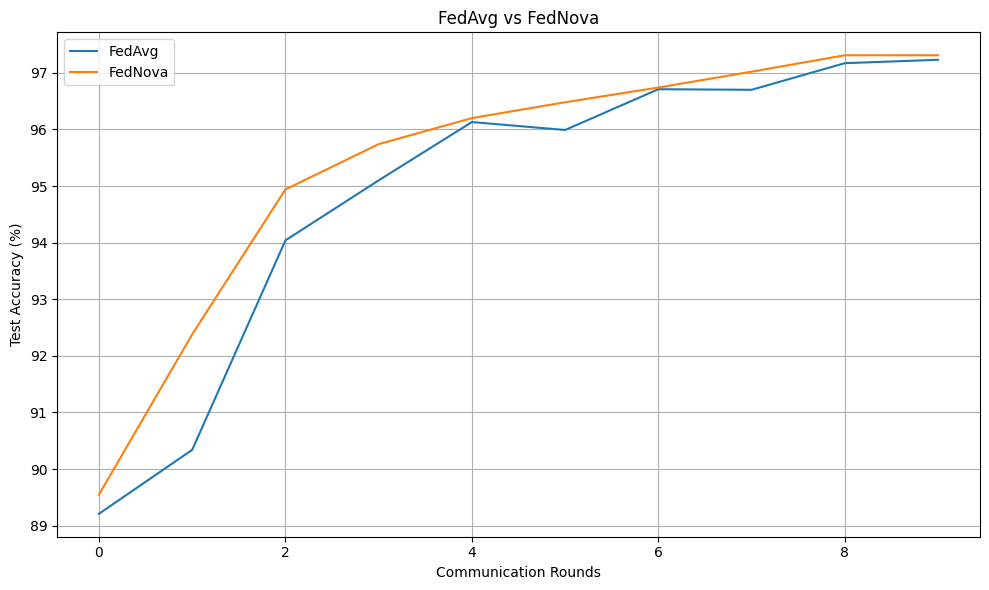

In [18]:
plt.figure(figsize=(10,6))
plt.plot(acc_fedavg, label="FedAvg")
plt.plot(acc_fednova, label="FedNova")
plt.xlabel("Communication Rounds")
plt.ylabel("Test Accuracy (%)")
plt.title("FedAvg vs FedNova")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()